# Lab 1: Introduction to Generative AI

The lab is divided in two parts.
In the first part, we will introduce simple generative models for a discrete and a continuous distribution.
The goal is to present the basics of training a probabilitic model.

In the second part, we study the generation of sentences with large languages models (LLMs).
Most LLMs are auto-regressive models which iteratively produce a discrete distribution of the next word.

## 0. Preconfiguration

We install the required libaries.

In [1]:
%pip install --quiet --upgrade transformers

Note: you may need to restart the kernel to use updated packages.


We import useful libraries.

In [2]:
import torch
from torch.distributions import Normal, Categorical, MixtureSameFamily, Independent
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/victor/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We check that a GPU is available.

In [3]:
torch.cuda.is_available()

True

In Google Colab, if the above code returns False, click on `Runtime`, `Change runtime type`, and choose `T4 GPU`. Then run the notebook again from the start.

## 1. A simple generative model for a discrete distribution

We consider a random variable $X$ with a categorical distribution over 3 classes $C_1$, $C_2$ and $C_3$.
The probabilities for each classes are $\mathbb{P}(X = C_1) = 0.1$, $\mathbb{P}(X = C_2) = 0.1$ and $\mathbb{P}(X = C_3) = 0.8$.

In [4]:
true_probabilities = [0.1, 0.1, 0.8]
true_dist = Categorical(torch.tensor(true_probabilities))

The probability simplex over three classes is a triangular representation used to visualize probability distributions.
Any point inside the triangle represents a probability distribution among the three classes. The closer a point is to a particular vertex, the higher the probability of that corresponding class.
A point exactly in the center would indicate equal probabilities for all three classes.
In the following plot, we indicate the true probability in the probability simplex.

In [5]:
#@title Simplex plotting function

import matplotlib.tri as tri
import matplotlib.pyplot as plt
import numpy as np


def plot_simplex(probas=None, true_probas=None):
    # Create a triangular grid
    corners = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1], [[0, 1, 2]])

    # Create the plot
    fig, axis = plt.subplots(figsize=(8, 7))
    axis.triplot(triangle, 'k-')

    # Label the vertices
    alignements = [('right', 'top'), ('left', 'top'), ('center', 'bottom')]
    labels = ['$C_3$', '$C_1$', '$C_2$']
    for i, corner in enumerate(corners):
        ha, va = alignements[i]
        axis.text(corner[0], corner[1], labels[i], ha=ha, va=va)

    if probas is not None:
        probas = np.array(probas)
        x = probas[:, 0] + probas[:, 1]/2
        y = probas[:, 1] * np.sqrt(3)/2
        plt.plot(x, y, 'o', markersize=5)

    if true_probas is not None:
        x = true_probas[0] + true_probas[1]/2
        y = true_probas[1] * np.sqrt(3)/2
        plt.plot(x, y, 'ro', markersize=5)

    # Set plot limits
    axis.set_xlim(-0.1, 1.1)
    axis.set_ylim(-0.1, 1.1 * np.sqrt(3)/2)

    axis.axis('off')
    plt.show()

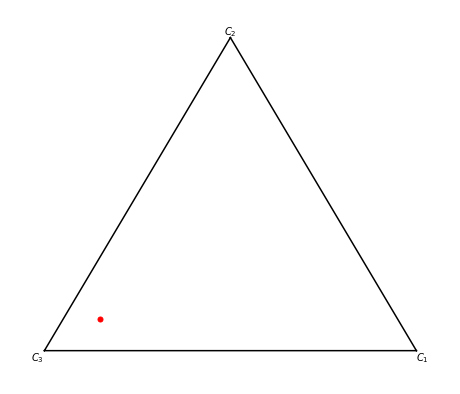

In [6]:
plot_simplex(true_probas=true_probabilities)

We suppose that we have access to a dataset of 1000 samples of $X$ and we show the first 20 instances.

In [7]:
X = true_dist.sample((1000,))
X[:20]

tensor([2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2])

We can estimate the distribution of $X$ by counting the number of samples in each class with a histogram.

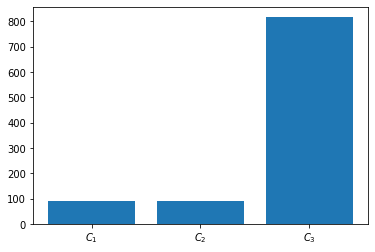

In [8]:
plt.bar(['$C_1$', '$C_2$', '$C_3$'], np.bincount(X))
plt.show()

In future labs, we will study the training procedure of Deep Generative Models.
To have a better understanding, we will estimate the distribution of $X$ with the same optimization procedure than Deep Generative Models: **maximum likelihood estimation** with **gradient descent**.
We define a PyTorch module for a categorical distribution with one parameter per class.
We use the softmax function to ensure that the probabilities sum to 1.

In [9]:
class CategoricalModule(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.logits = torch.nn.Parameter(torch.zeros(n_classes))

    def dist(self):
        probs = torch.softmax(self.logits, dim=-1)
        return Categorical(probs)

We can access the probabilities of our distribution using `.probs`.

In [10]:
module = CategoricalModule(3)
module.dist().probs

tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)

We can also sample using `.sample()` and evaluate the probability of a sample using `.log_prob()`.

In [11]:
sample = module.dist().sample()
print(sample)
print(module.dist().log_prob(sample).exp())

tensor(2)
tensor(0.3333, grad_fn=<ExpBackward0>)


In this code, we perform maximum likelihood estimation using gradient descent with the optimizer Adam.

In [12]:
def train(X, lr=0.01, nb_steps=300):
    module = CategoricalModule(3)
    loss_list = []
    probs_list = []
    
    optimizer = torch.optim.Adam(module.parameters(), lr=lr)
    for step in range(nb_steps):
        optimizer.zero_grad()
        dist = module.dist()
        # We compute the negative log-likelihood of the samples
        loss = -dist.log_prob(X).mean()
        # We compute the gradients
        loss.backward()
        # We modify the parameters using gradient descent
        optimizer.step()
        loss_list.append(loss.item())
        # We collect the probabilities every 20 steps
        if step % 20 == 0:
            probs = dist.probs.detach().numpy()
            probs_list.append(probs)
    
    plot_simplex(probas=probs_list, true_probas=true_probabilities)
    plt.plot(loss_list)

We plot the probability simplex with the estimated probabilities per step in blue and the true probability in red.

Can you plot the loss per step?

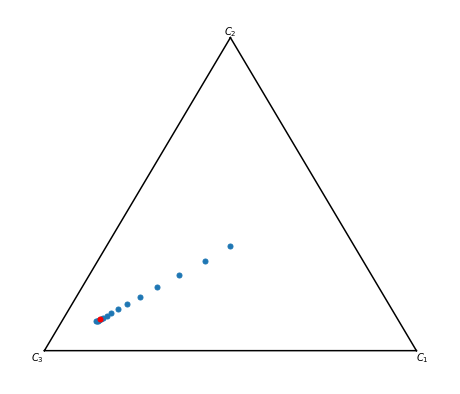

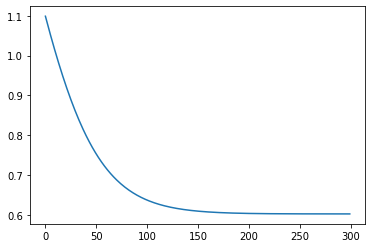

In [13]:
# Note: the plot was added inside of a function to make it easier to compare the results.
train(X, lr=0.01, nb_steps=300)

You can experiment with other learning rates `lr` and number of steps `nb_steps`. What do you observe?

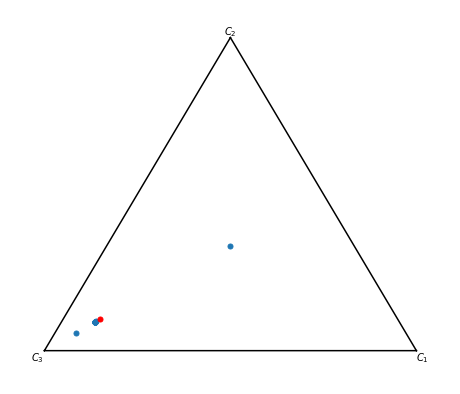

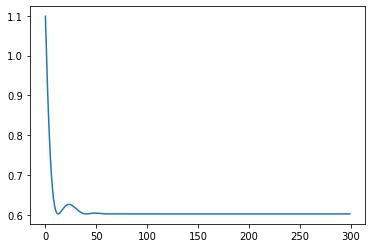

In [14]:
train(X, lr=0.1, nb_steps=300) # A higher learning rate leads to a faster convergence (but there is some instability in the loss)

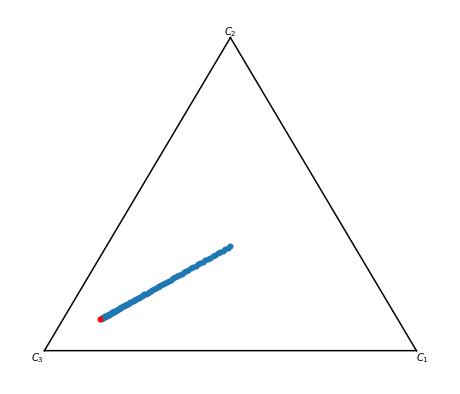

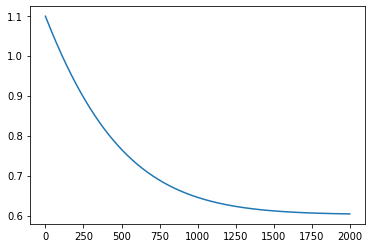

In [15]:
train(X, lr=0.001, nb_steps=2000) # A lower learning rate leads to a slower convergence

Suppose that we change the true probabilities to the probabilities defined below.

Can you execute the optimization algorithm with these true probabilities?

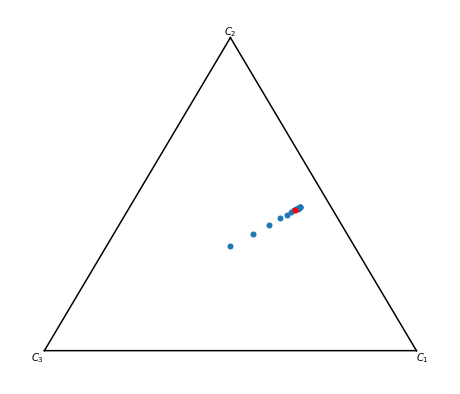

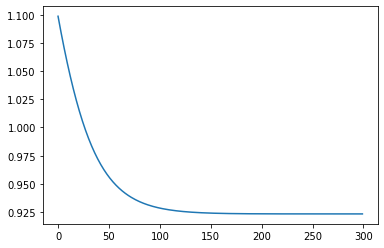

In [16]:
true_probabilities = [0.45, 0.45, 0.1]
true_dist = Categorical(torch.tensor(true_probabilities))
X = true_dist.sample((1000,))

train(X, lr=0.01, nb_steps=300)

## 2. A simple generative model for a continuous distribution

We now consider a generative model for a two-dimensional continuous variable $X \in \mathbb{R}^2$ from the dataset *moons*. We have access to a datasets of 1000 samples.

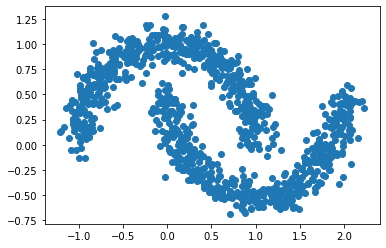

In [17]:
X, _ = make_moons(n_samples=1000, noise=0.1)
X = torch.from_numpy(X).float()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

We define a PyTorch module for a Gaussian mixture model where the mean, standard deviation and weight of each component are estimated.

In [18]:
class MixtureModule(torch.nn.Module):
    def __init__(self, n_components, d):
        super().__init__()
        self.mean = torch.nn.Parameter(torch.randn((n_components, d)))
        self.rho = torch.nn.Parameter(torch.ones_like(self.mean))
        self.logits = torch.nn.Parameter(torch.zeros(n_components))

    def dist(self):
        probs = torch.softmax(self.logits, dim=-1)
        stddev = torch.nn.Softplus()(self.rho) + 1e-5
        return MixtureSameFamily(Categorical(probs), Independent(Normal(self.mean, stddev), 1))

We can access the means, standard deviations and weights using the following code.

In [19]:
module = MixtureModule(3, 2) # 3 components, 2 dimensions
dist = module.dist()
print(dist.component_distribution.mean)
print(dist.component_distribution.stddev)
print(dist.mixture_distribution.probs)

Parameter containing:
tensor([[ 1.3151,  0.3938],
        [ 0.6300, -0.1914],
        [-0.2531, -0.0079]], requires_grad=True)
tensor([[1.3133, 1.3133],
        [1.3133, 1.3133],
        [1.3133, 1.3133]], grad_fn=<SqrtBackward0>)
tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)


As for the categorical distribution, we can also sample using `.sample()` and evaluate the probability of a sample using `.log_prob()`.

In [20]:
sample = module.dist().sample()
print(sample)
print(module.dist().log_prob(sample).exp())

tensor([-1.4400,  0.7036])
tensor(0.0280, grad_fn=<ExpBackward0>)


Can you plot 1000 samples?

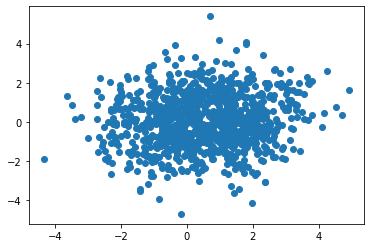

In [21]:
samples = dist.sample((1000,))
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()

As before, we estimate the parameters using maximum likelihood estimation with gradient descent.

Modify the code to:
1. Collect the loss at each step and plot the loss per step at the end of training.
2. Plot samples of the estimated distribution after steps 0, 500, 1000, ..., 3500.
3. On the same plot, add the mean of each component of the mixture.

You can take inspiration from the training code for the discrete distribution (Section 1).

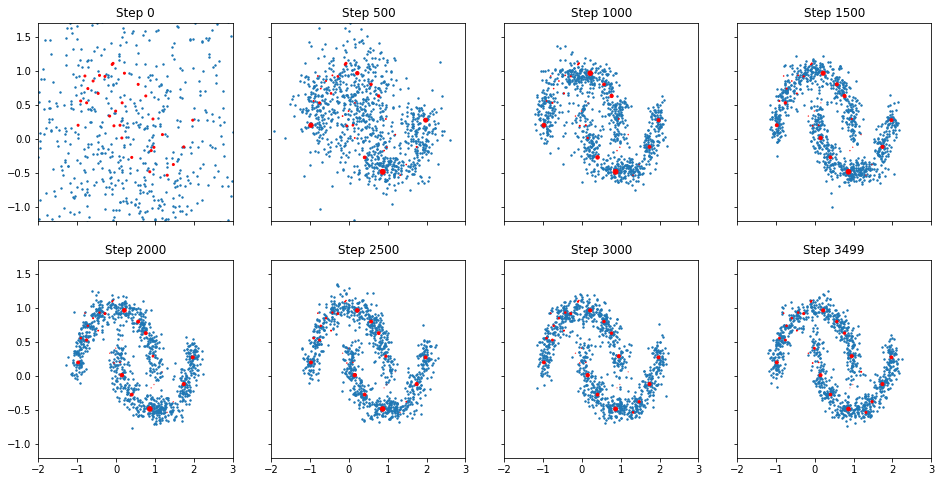

In [22]:
def plot_samples(results_list):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
    for axis, results in zip(axes.flatten(), results_list):
        step, samples, means, weights = results
        axis.scatter(samples[:, 0], samples[:, 1], s=2)
        axis.scatter(means[:, 0], means[:, 1], color='red', s=weights * 30 * 4)
        axis.set_title(f"Step {step}")
        axis.set(xlim=(-2, 3), ylim=(-1.2, 1.7))
    plt.show()


def train(X, lr=0.004, nb_steps=3500):
    module = MixtureModule(30, 2)

    loss_list = []
    results_list = []
    interval = nb_steps // 7

    optimizer = torch.optim.Adam(module.parameters(), lr=lr)
    for step in range(nb_steps):
        optimizer.zero_grad()
        dist = module.dist()
        loss = -dist.log_prob(X).mean()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if step % interval == 0 or step == nb_steps - 1:
            samples = dist.sample((1000,)).detach()
            means = dist.component_distribution.mean.detach()
            weights = dist.mixture_distribution.probs.detach()
            results_list.append((step, samples, means, weights))

    # For better visualization, we store the results and plot the samples in a 2x4 grid instead of a single plot per step
    plot_samples(results_list)


train(X, lr=0.004, nb_steps=3500)

Experiment with other learning rates `lr` and number of steps `nb_steps`. What do you observe?

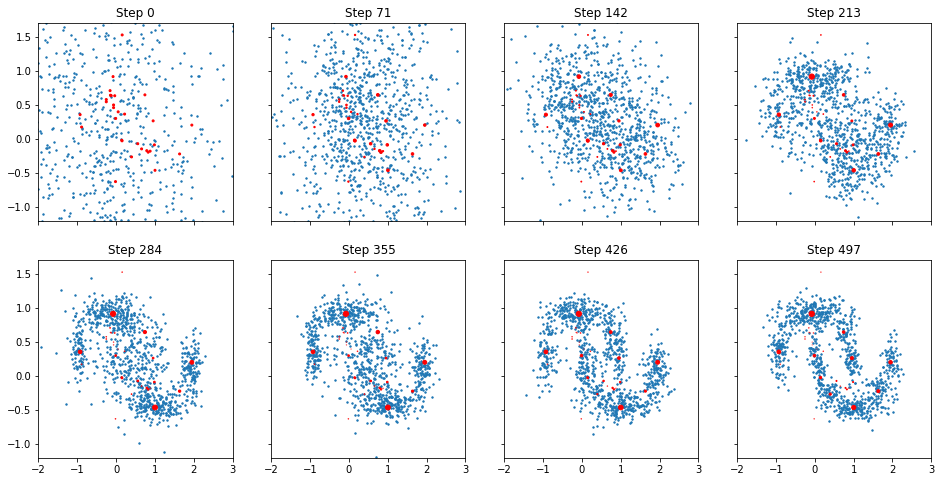

In [23]:
train(X, lr=0.1, nb_steps=100) # For a simple distribution like this one, a higher learning rate is fine

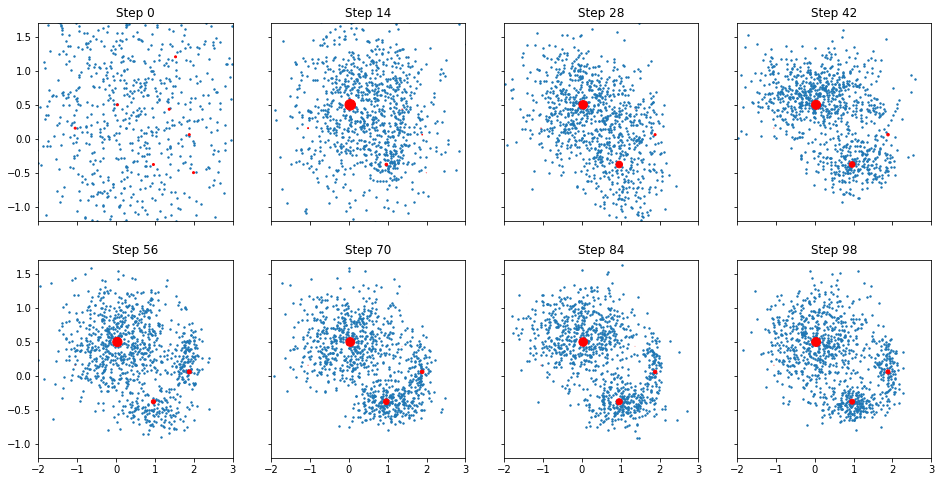

In [33]:
train(X, lr=1, nb_steps=100) # Learning rates that are too high can lead to instability

One limitation of generative models is that they can learn to copy data. This phenomenon is known as overfitting.
This will be especially the case if there is less data than parameters.

In the previous experiment, we used a dataset of size 1000. Can you create a dataset of size 10, run the training algorithm, and note your observations?

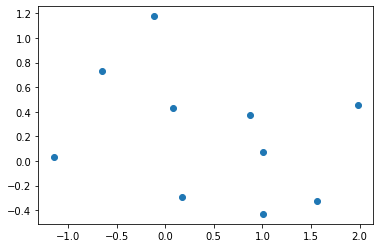

In [25]:
X, _ = make_moons(n_samples=10, noise=0.1)
X = torch.from_numpy(X).float()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

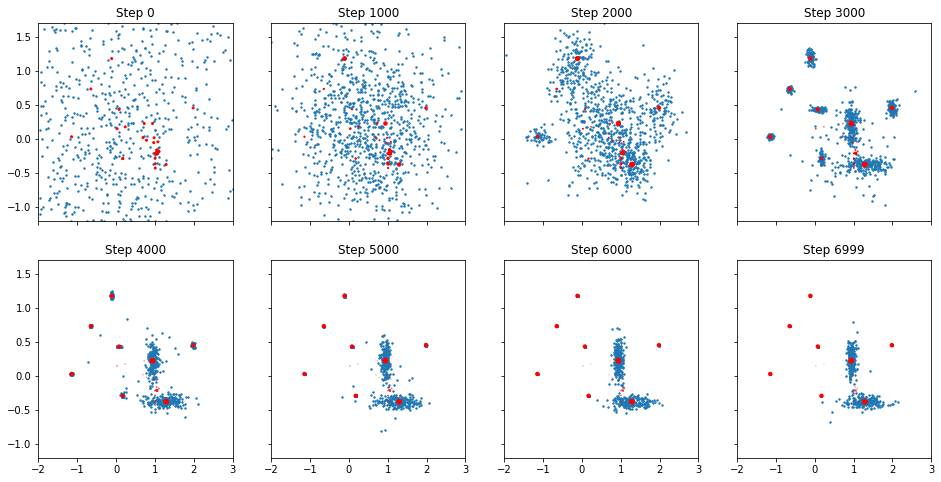

In [26]:
train(X, lr=0.001, nb_steps=7000) # We observe that the distribution is too flexible and becomes concentrated on the individual points of the dataset.

## 3. Large language models (LLMs)

We consider the model GPT-2 (Generative Pre-trained Transformer 2), which has been developed by OpenAI in 2019.

It has been trained on BookCorpus, a dataset of over 7,000 self-published fiction books from various genres, and trained on a dataset of 8 million web pages.

In contrast to GPT-3 and GPT-4, it is an open-source models, which means that its parameters have been released to the public.

We first download and load the parameters of the large version of the model (774 million parameters).

In [27]:
#model_name = "llmware/bling-1b-0.1"
model_name = "gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

We count the total number of parameters by summing the number of elements in each group of parameters `p`.

In [28]:
sum(p.numel() for p in model.parameters())

774030080

First, we encode an input text to a list of numbers using a tokenizer.

In [29]:
input_text = "My favorite food is"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
input_ids

tensor([[3666, 4004, 2057,  318]])

By calling the model, we get *logits*, which are then transformed into probabilities using the *softmax* function.

In [30]:
model.eval()
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)
logits = outputs.logits
# We take the probabilities of the last token (the one we want to predict)
next_token_logits = logits[0, -1, :]
probabilities = torch.softmax(next_token_logits, dim=-1)

For illustration, we show the probabilities assigned to the 10 most likely classes and the 10 less likely classes.

The first plot is in linear scale, while the second plot is in log scale so that the smallest probabilities are visible.

Note: Ġ indicates the start of a word.

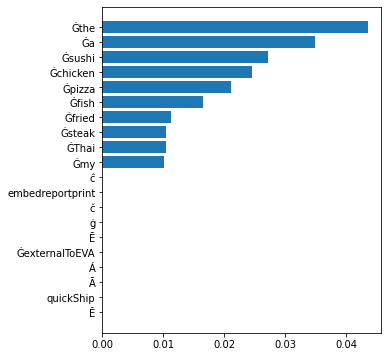

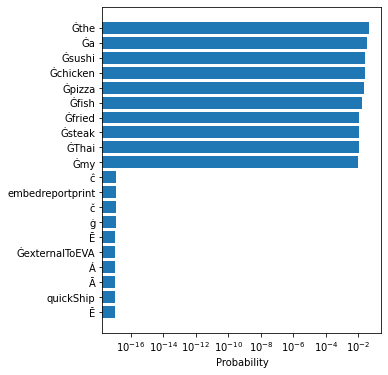

In [31]:
# We get the sorted probabilities and IDs
tokens_probas, tokens_ids = probabilities.sort()
# We select the top 10 and bottom 10 tokens
tokens_ids = torch.cat([tokens_ids[:10], tokens_ids[-10:]])
tokens_probas = torch.cat([tokens_probas[:10], tokens_probas[-10:]])
# We convert the tokens indices to strings
tokens = tokenizer.convert_ids_to_tokens(tokens_ids)
# Horizontal bar plot, first with linear scale, then with log scale
for log_scale in [False, True]:
    fig, axis = plt.subplots(figsize=(5, 6))
    axis.barh(tokens, tokens_probas, orientation='horizontal')
    if log_scale:
        axis.set_xscale('log')
        axis.set_xlabel('Probability')
    plt.show()

In the above example, we observe that there is high uncertainty on the next word in the sentence.

Can you think of a sentence `input_text` for which there would be low uncertainty on the next word? Then, check that this is indeed the case.

In [32]:
input_text = 'To be or not to' # By running the code with this value of `input_text`, we observe that the model puts a probability of almost 1 to the token "be".

As in Section 1, we can create a categorical distribution of the next word and sample from it. Then, we can decode the token ID.

In [33]:
dist = Categorical(probs=probabilities)
next_token_id = dist.sample()
tokenizer.decode(next_token_id)

' vegetables'

Finally, we generate a full sentence one word at a time using an auto-regressive sampling procedure.

We use a more recent model for better results. Note that this model is still relatively small (1 billion parameters) compared to recent LLMs (e.g., 175 billion parameters for GPT-3).

Can you display the probability of the sampled word at each step?

In [34]:
def generate_sentence_with_probabilities(model, tokenizer, initial_text, temperature=1., max_length=20):
    input_ids = tokenizer.encode(initial_text, return_tensors='pt')
    model.eval()

    sentence = initial_text
    token_probs = []

    for _ in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
        logits = outputs.logits
        # (Section 4): Implement the temperature here
        logits = logits / temperature
        next_token_logits = logits[0, -1, :]
        probabilities = torch.softmax(next_token_logits, dim=-1)
        # Choose the most probable next token
        dist = Categorical(probs=probabilities)
        next_token_id = dist.sample(torch.Size([1]))
        # Or choose the most probable token
        #next_token_id = probabilities.argmax().unsqueeze(0)
        # Compute the probability of the chosen token
        token_prob = probabilities[next_token_id].item()
        token_probs.append(token_prob)
        # Append the token to the input_ids
        input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=1)
        # Decode the token to append it to the sentence
        next_word = tokenizer.decode(next_token_id)
        print(f'{next_word}')

        sentence += next_word
        if next_word == tokenizer.eos_token:
            break
    return sentence, token_probs

# Load pre-trained model and tokenizer
model_name = "llmware/bling-1b-0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Generate a sentence
initial_text = "I like playing with large language models because"

sentence, token_probs = generate_sentence_with_probabilities(model, tokenizer, initial_text)

 they
 feel
 more
 natural
.”
 —
rish
ag


what
 is
 the
 impact
 with
 large
 language
 models
?


<


In [35]:
print("Generated Sentence:", sentence)
print("Token Probabilities:", token_probs)

Generated Sentence: I like playing with large language models because they feel more natural.” —rishag
what is the impact with large language models?
<
Token Probabilities: [0.18659639358520508, 0.005601740442216396, 0.30760133266448975, 0.40364328026771545, 0.00762241892516613, 0.012021186761558056, 2.388838083788869e-06, 0.005829712375998497, 0.0029392861761152744, 0.5856303572654724, 0.6383587121963501, 0.8184642791748047, 0.0033460676204413176, 0.00635087164118886, 0.4566447138786316, 0.8620706796646118, 0.9846195578575134, 0.7653689980506897, 0.9817865490913391, 0.9991851449012756]


Can you modify the above code to predict the most probable word at each step instead of sampling from a categorical distribution?

## 4. Optional experiments

We can increase or decrease the uncertainty of the model with a hyperparameter $t$ called the **temperature** which influences the level of creativity in the responses.

In practice, we can implement this easily by dividing the logits by $t$: `logits = logits / t`.

When set high, it produces more inventive and imaginative text. Conversely, a lower temperature yields responses that are more precise and factual. A temperature of 1 will have no effect.

Modify the above code to a temperature parameter. Then, you can try very values of temperature such as `1e-5`, which will produce more factual outputs and `1.2`, which will produce more creative outputs.

In [36]:
sentence, token_probs = generate_sentence_with_probabilities(model, tokenizer, initial_text, temperature=1e-5)
print("Generated Sentence:", sentence)
print("Token Probabilities:", token_probs)

 it
 makes
 it
 easier
 to
 reason
 about
 the
 language
 model
.
  
I
 like
 the
 fact
 that
 it
 is
 easy
Generated Sentence: I like playing with large language models because it makes it easier to reason about the language model.  I like the fact that it is easy
Token Probabilities: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [37]:
sentence, token_probs = generate_sentence_with_probabilities(model, tokenizer, initial_text, temperature=1.2)
print("Generated Sentence:", sentence)
print("Token Probabilities:", token_probs)

 cutting
 language
 out
can
 help
 improve
 the
 speed
 and
 perform
anc
et
urns
 better
 in
 autore
const
ructions
ense
ansas
Generated Sentence: I like playing with large language models because cutting language outcan help improve the speed and performanceturns better in autoreconstructionsenseansas
Token Probabilities: [8.48950949148275e-05, 0.010613411664962769, 0.030410215258598328, 0.00027815671637654305, 0.02614886313676834, 0.016259633004665375, 0.07765103876590729, 0.031972821801900864, 0.13733230531215668, 0.0018998838495463133, 0.16472870111465454, 0.15012571215629578, 0.024479210376739502, 0.0035081140231341124, 0.03247549384832382, 1.1641000128292944e-05, 5.246569708106108e-05, 0.9337447881698608, 0.0010452362475916743, 4.515779892244609e-06]


Larger languages models require more GPU memory than what is available in Google Colab. If you have a GPU with sufficient memory, you can experiment with more recent LLMs such as Llama-2. These models are open-source at the condition of accepting license terms (see [here](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf)).
This process can take a few minutes to 2 days.
You can then generate an authentication token [here](https://huggingface.co/settings/tokens) and run the command below with your authentication token.

In [ ]:
!huggingface-cli login --token <YOUR_TOKEN>

The model can then be instantiated with this code in a similar way than the models from Section 3.

In [39]:
from transformers import LlamaTokenizer, LlamaForCausalLM

model_name = "meta-llama/Llama-2-7b-chat-hf"
model = LlamaForCausalLM.from_pretrained(model_name)
tokenizer = LlamaTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [41]:
sentence, token_probs = generate_sentence_with_probabilities(model, tokenizer, initial_text)

you
can
have
a
lot
of
fun
with
them
.
Here
are
some
ideas
.




1
.
Ask
